In [1]:
import time
import copy
import numpy as np
import pandas as pd
import seaborn as sn
from tqdm import tqdm
import matplotlib.pyplot as plt

import sklearn
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

from models import *
from utils import *
from datasets import *

In [2]:
import torchvision as tv
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision.utils import save_image

# Data Preprocessing

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainTransform  = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize((0.1307,), (0.3081,))])
trainset = tv.datasets.MNIST(root='./data',  train=True, download=False, transform=transform)
testset = tv.datasets.MNIST(root='./data',  train=False, download=False, transform=transform)

# # sample
# idx = np.random.choice(np.arange(len(trainset)), size=10000)
# trainset = [trainset[i] for i in idx]
# idx = np.random.choice(np.arange(len(testset)), size=10000)
# testset = [testset[i] for i in idx]

traindata = [i[0].unsqueeze(0) for i in trainset]
trainlabel = [i[1] for i in trainset]
testdata = [i[0].unsqueeze(0) for i in testset]
testlabel = [i[1] for i in testset]

X_train = torch.vstack(traindata)
y_train = torch.tensor(trainlabel)
X_test = torch.vstack(testdata)
y_test = torch.tensor(testlabel)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([60000, 1, 28, 28]),
 torch.Size([10000, 1, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000]))

In [3]:
X_train = X_train.view(-1, 28*28)
X_test = X_test.view(-1, 28*28)

In [22]:
z = torch.load("./data/Z_pretrainDR_60k.pt")
z = normalise(z.numpy())
z.shape

(60000, 2)

In [23]:
from sklearn.svm import SVC

svc = SVC(kernel='rbf', decision_function_shape='ovo')
svc.fit(z, y_train)

SVC(decision_function_shape='ovo')

In [26]:
y_pred = svc.predict(z)
sklearn.metrics.accuracy_score(y_pred=y_pred, y_true=y_train.numpy())

0.96175

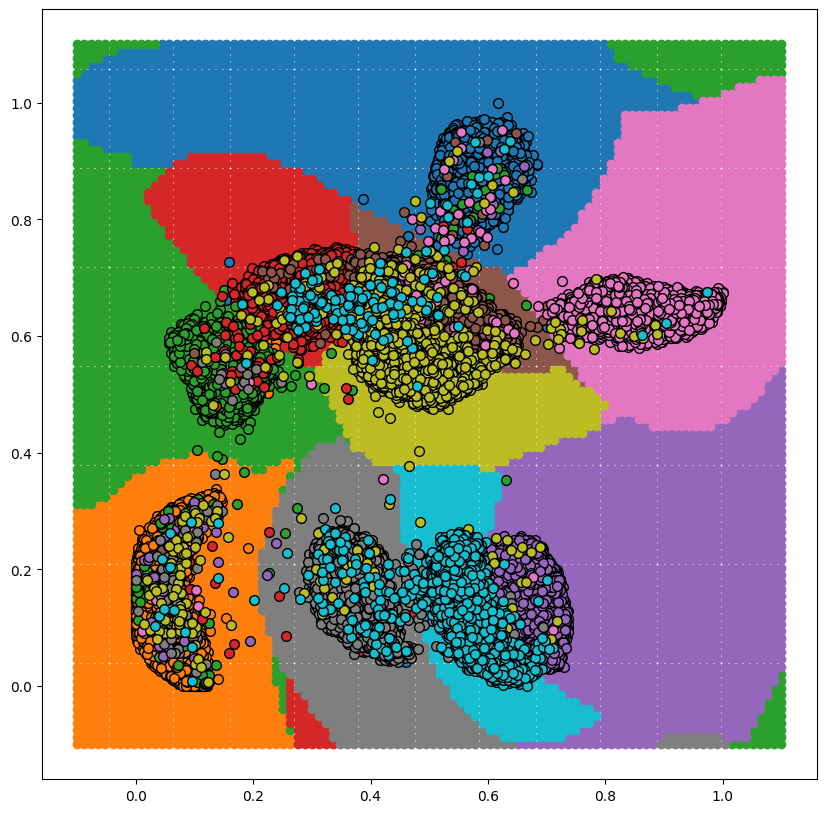

In [24]:
num_classes = 10

def getGrid(n=100, rim=0.1):
    """generate quadratic gridover unit square plus rim"""
    nx,ny= (n,n)
    x=np.linspace(-rim,1+rim,nx)
    y=np.linspace(-rim,1+rim,ny)
    xv,yv=np.meshgrid(x,y)
    return np.array([a for a in zip(xv.flat,yv.flat)])

G = getGrid()

pred = svc.predict(G)
# pred = np.argmax(pred,axis=1)

# plot prediction and training data
fig,ax =plt.subplots(figsize=(10,10))
for i in range(num_classes):
    s = G[pred==i]
    ax.plot(s[:,0],s[:,1],".",ms=12)
plt.gca().set_prop_cycle(None)
for i in range(num_classes):
    # s = X_test[y_test_orig==i]
    s = z[y_train==i]
    ax.plot(s[:,0],s[:,1],"o",ms=7, markeredgecolor='black',
         markeredgewidth=1)